# 关于Swin Transformer的两个细节点
- cyclic shift
- Relative position bias

### 1、关于cyclic shift操作
由于基于窗口的自注意模块缺乏跨窗口的连接，这限制了其建模能力。为了在保持非重叠窗口高效计算的同时引入跨窗口连接，作者提出了一种移位窗口划分方法，该方法在连续的swin transformer block中交替使用两种划分方法。其中第二种划分方式SW-MSA也有两种窗口分配方式，这里谈的主要是第二种方式即cyclic shift，这种方式巧妙的降低的计算量，使得shifted windows的数量保持不变。可以看到作者团队花了一定的工作在Shifted  Windows上面，从直觉上讲这种操作可以弥补非重叠窗口的信息，作者也做了一些消融实验验证这种技巧的可行性，不管是否是该操作导致最终好的效果还是其他，至少现在应该仔细推敲推敲其实现的细节。
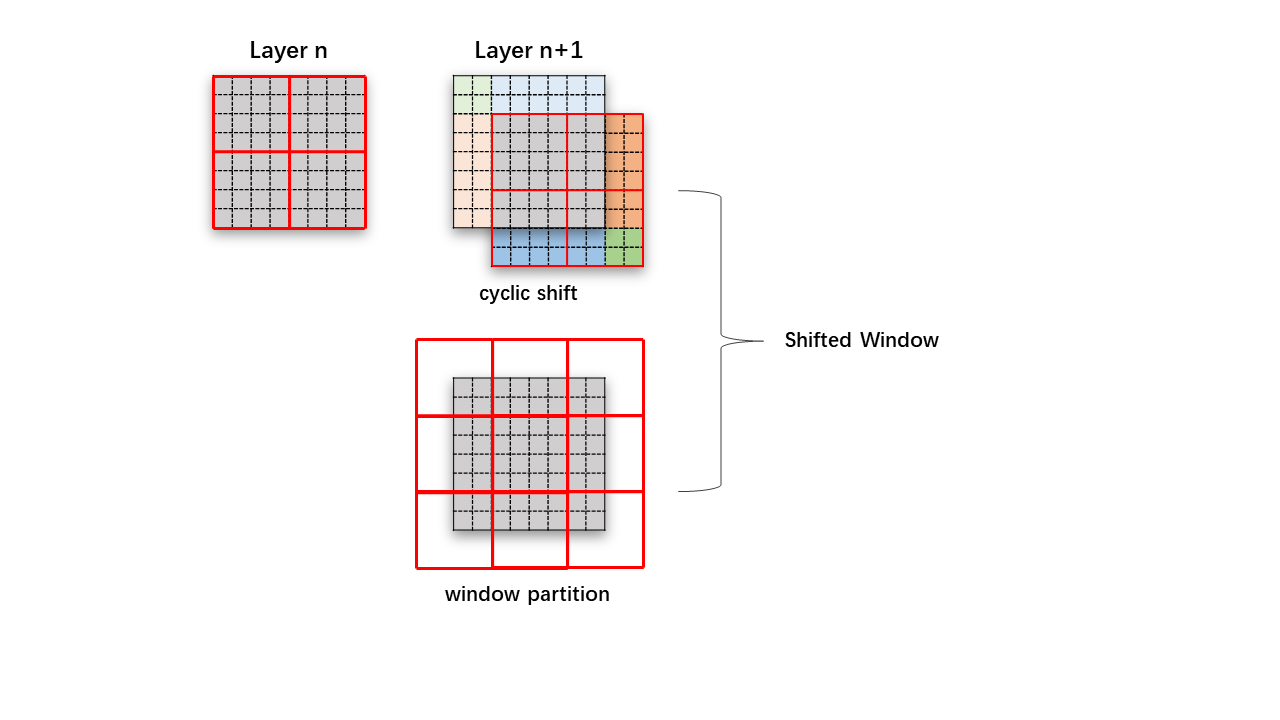

关于原文的cyclic shift操作我认为作者并没有讲的太清楚，通过阅读源代码才明白该操作的意思，根据其用意我又重新绘制了一遍原理图，看起来似乎跟原文的图没大有区别，一会还是结合代码描述才能更清晰。首先第一行两张图的红色方框表示移位窗口（虚线框表示patch），可以看到窗口整体向右下平移了一个窗口一半的尺寸，蓝绿黄三种浅色块表示原来的位置，他们经过旋转平移到深色块对应的位置，然后就跟平移过后的窗口对应上了，在这个例子中依旧保持了2X2个窗口。

[]

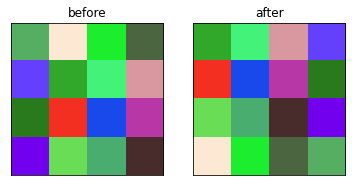

In [16]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

class Shift:
    def __init__(self, window_size = 2):
        self.shift_size = window_size // 2
    def get_shift(self, x):
        shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        return shifted_x
    __call__ = get_shift
    
x = torch.randint(0,255,size=(3,4,4))
shift = Shift()
ax = plt.subplot(1, 2, 1)
ax.imshow(x.permute(1,2,0))
ax.set_title("before")
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1, 2, 2)
ax.imshow(shift(x).permute(1,2,0))
ax.set_title("after")
ax.set_xticks([])
ax.set_yticks([])

以这个4X4的图例演示，可以看到这个操作实际就是将左上角那一圈转到右下角了，原始的核心代码只有这一行：`shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))`

In [108]:
from typing import Any, List, Callable, Tuple
import math

class Shifted_Window:
    def __init__(self, input_x: Any, window_size: int=7, patch_size: int=4, mask: bool=False):
        self._input = input_x
        self._window_size = window_size
        self._input_shape = input_x.shape[-2:]
        self._window_num = (math.ceil(self._input_shape[0] / (window_size*patch_size)),
                            math.ceil(self._input_shape[0] / (window_size*patch_size)))
        self._patch_size = patch_size
        self.mask = mask
        self._shift_size = self._window_size//2
        if mask:
            self.mat_index = torch.zeros((self._input_shape[0]//patch_size, self._input_shape[1]//patch_size))
            self.w_index = torch.arange(0, (self._window_num[0]+1)*window_size+1, window_size)-window_size+(window_size//2)
            self.h_index = torch.arange(0, (self._window_num[1]+1)*window_size+1, window_size)-window_size+(window_size//2)
            for i in range(self._window_num[0]+1):
                for j in range(self._window_num[1]+1):
                    self.mat_index[max(0, int(self.w_index[i].item())):min(int(self.w_index[i+1].item()),self._input_shape[0]),
                                   max(0, int(self.h_index[j].item())):min(int(self.h_index[j+1].item()),self._input_shape[1])]\
                    = i*(self._window_num[0]+1)+j
    
    @property
    def window_size(self):
        return self._window_size
    
    @property
    def input_shape(self)->Tuple:
        return self._input_shape
    
    @property
    def window_num(self):
        return self._window_num
    
    @property
    def patch_size(self):
        return self._patch_size
    
    @staticmethod
    def _get_chip(m, size_h, size_w, size_win):
        chip_list = []
        for i in range(size_w):
            for j in range(size_h):
                chip_list.append(m[i*size_win:min((i+1)*size_win, size_w*size_win),
                                   j*size_win:min((j+1)*size_win, size_h*size_win)])
        return chip_list
    
    def get_mask(self):
        return_mask = []
        assert self.mask, "not cyclic mode"
        self.mat_index =  torch.roll(self.mat_index, shifts=(-self._shift_size, -self._shift_size), dims=(-2, -1))
        for i in Shifted_Window._get_chip(self.mat_index, self._window_num[0], self._window_num[1], self._window_size):
            tmp_mat = torch.meshgrid(i.flatten(), i.flatten())
            tmp_mask = torch.zeros_like(tmp_mat[0])
            tmp_mask[(tmp_mat[0]-tmp_mat[1])!=0] = -100
            return_mask.append(tmp_mask)
        return return_mask
            
    
x = torch.rand((4,3,11,11))
shift = Shifted_Window(x, window_size=3, patch_size=1, mask=True)
shift.get_mask()

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         

可以看到以上的手写代码基本实现了生成mask的功能，填入不规则的窗口尺寸依然能得到对应结果。其目的是在计算自注意力的时候忽略掉来自不同块的相互注意力，将mask加入-100或其他的一个极大的负值会被softmax忽略掉，但值得讨论的是经过softmax的scaled后这个缩放系数依然是有可能来自不同区域像素块的，至少是与使用window partition的方法是正相关的。
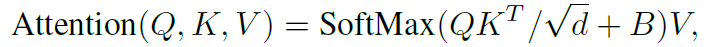

### 2、关于Relative position bias
本文章在pos embedding中主要使用的是Relative position bias，与ViT不同，这里作者做了消融实验证明了相对位置编码的有效性。其做法是生成一个pa相对位置的值域范围的表，如文章默认7X7的窗口尺寸即每个窗口在水平和数值方向分别有相对位置的值域(-7+1,7-1)，生成的表就是13X13尺寸的表，该表中的参数是可以学习的，行列的下标分别水平或垂直方向的相对距离，为了索引方便，算出来的相对位置应当将值域与表的下标对应起来，即加(7-1)。计算出每一个patch的相对位置后到表中索引即可。

In [197]:
## 计算相对位置
class Relative_position:
    def __init__(self, window_size: int=7, head_num: int=8):
        self._window_size = window_size
        self.table = torch.nn.Parameter(
            torch.zeros(head_num,2*window_size-1,2*window_size-1).flatten()
        )
        
    @staticmethod
    def _get_pos(win_size):
        pos_mat = torch.stack(torch.meshgrid(torch.arange(win_size), torch.arange(win_size))).flatten(-2)
        # 源代码中使用的广播相减，更加简介方便
        pos_rela = pos_mat[:,:,None]-pos_mat[:,None,:]+win_size-1
#         pos_rela = pos_mat.unsqueeze(0).repeat((win_size**2),1,1).T
#         pos_mat = pos_mat.unsqueeze(0).repeat((win_size**2),1,1)
#         pos_rela = pos_mat-pos_rela+win_size-1
        pos_rela[0,:,:] *= (win_size*2-1)
        return pos_rela.sum(axis=0).T
    
    def get_bias(self):
        index = Relative_position._get_pos(self._window_size)
        return self.table[index].contiguous()
        
        
relativa_bias = Relative_position(3)
relativa_bias.get_bias(), relativa_bias._get_pos(3)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<CopyBackwards>),
 tensor([[12, 13, 14, 17, 18, 19, 22, 23, 24],
         [11, 12, 13, 16, 17, 18, 21, 22, 23],
         [10, 11, 12, 15, 16, 17, 20, 21, 22],
         [ 7,  8,  9, 12, 13, 14, 17, 18, 19],
         [ 6,  7,  8, 11, 12, 13, 16, 17, 18],
         [ 5,  6,  7, 10, 11, 12, 15, 16, 17],
         [ 2,  3,  4,  7,  8,  9, 12, 13, 14],
         [ 1,  2,  3,  6,  7,  8, 11, 12, 13],
         [ 0,  1,  2,  5,  6,  7, 10, 11, 12]]))